# Objectives

1. Animated Subtree

1. Sampling Bias
    - A. Full
    - B. Russia "Knockout"
    - C. Germany "Knockout"
1. Geocoding Bias
1. Drawing Bias

---
# Setup

## Modules

In [1]:
import os
import dill
import copy
import math

from Bio import Phylo
import pandas as pd
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib import lines, patheffects, animation, gridspec

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "geo"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

BASEMAP = cimgt.Stamen('terrain-background')
NAME_COL = "Name"

In [3]:
import sys, importlib
importlib.reload(sys.modules['config'])
from config import *

## File Paths

In [4]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")

outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
#tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
#tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_path    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_timetree.nwk")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

#print("tree_dill:\t", tree_dill)
#print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "geo_animate"

aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/geo/all/chromosome_filter5


## Import Tree

In [5]:
# with open(tree_dill, "rb") as infile:
#     tt = dill.load(infile)
# tt.tree.ladderize(reverse=False)

tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [6]:
# with open(tree_df_dill, "rb") as infile:
#     tree_df = dill.load(infile)
# display(tree_df)

tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Import Colors

In [7]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)

# Add sizes
colors_df["Size"] = [NO_DATA_CHAR for i in range(0,len(colors_df))]
i = 0
for attr in list(dict.fromkeys(colors_df["Attribute"])):
    title_attr = attr.replace("_"," ").title().replace(" ","_")
    attr_df =  colors_df[colors_df["Attribute"] == attr]
    for state in attr_df["State"]:
        if attr == "branch_number":
            state = int(state)
        matches = tree_df[tree_df[title_attr] == state]
        colors_df.at[i,"Size"] = len(matches)
        i += 1

display(colors_df)
    
# Convert to dict
colors_dict = {}
sizes_dict = {}
for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    size = rec[1]["Size"]

    if attr not in colors_dict:
        colors_dict[attr] = {}
    if attr not in sizes_dict:
        sizes_dict[attr] = {}        
    colors_dict[attr][state] = color        
    sizes_dict[attr][state] = size

,Attribute,State,Color,Size
0,branch_number,0,#8000ff,210
1,branch_number,3,#00b4ec,12
2,branch_number,4,#80ffb4,15
3,branch_number,2,#ffb462,173
4,branch_number,1,#ff0000,206
...,...,...,...,...
202,province,Midlands,#ff1c0e,1
203,province,State of Mato Grosso,#ff150b,1
204,province,MSila,#ff0e07,1
205,province,La Paz,#ff0704,1


---
# 1. Animate

In [8]:
# Ancient Plagues
# 0.PRE, 0.ANT4, 1.PRE

attr         = "Branch_Major"
#attr_val     = "1.PRE"
attr_val     = "0.PRE"
attr_color   = colors_dict["branch_major"][attr_val] 
geo_attr     = "Province"

## Colorize Tree

In [9]:
for c in tree.find_clades():
    state = tree_df["Mugration_" + attr][c.name]
    color = colors_dict[attr.lower()][state]
    c.color = color

## Create Subtree and Dataframe

In [11]:
clade_df = tree_df[tree_df["Mugration_" + attr] == attr_val]
clade = tree.common_ancestor(clade_df.index)
try:
    parent_node = copy.deepcopy(get_parent(tree, clade.root.name))
    parent_rec = tree_df[tree_df.index.str.contains(parent_node.name)]
    clade = parent_node
    clade_df = clade_df.append(parent_rec)
except AttributeError:
    pass

# Prune clades outside
prune_nodes = []

for c in clade.find_clades(order="postorder"):
    if c.name not in clade_df.index:
        prune_nodes.append(c)
        
for node in prune_nodes:
    if node in clade.find_clades(node):
        try:
            clade.prune(node)
        except AttributeError as e:
            print(e)
            continue

# Clean up dataframe
for node in clade_df.index:
    if node not in [c.name for c in clade.find_clades()]:
        clade_df.drop(node, inplace=True)


display(clade_df)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0.001000,16.18967,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.294307e-09,1.000000,1.000000e-03,-3969-10-31,-3968.168257,"[-4053.4696667283065, -3775.871275763169]","[6074.469666728306, 5796.871275763169]",0.100000,0.100000,16.18967,-3968.168257,0.000000,False,0,1.0,8.700696e-08,0.PRE,0.998722,9.834317e-03,0.PRE2,0.392421,1.329438e+00,Russia,0.992283,4.913267e-02,64.686314,97.745306,Krasnoyarsk Krai,0.382134,1.653172e+00,63.323381,97.097997
SAMEA3541827,NA,NA,3.8504e-06,grey,0.001003,1.00000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.921218e-09,0.314302,3.440082e-06,-2879-04-29,-2878.676074,"[-2876.0, -2677.0]","[4897.0, 4698.0]",1089.492183,1089.592183,1.00000,-2776.500000,0.000003,False,0,1.0,-1.000089e-12,0.PRE,1.000000,-1.000089e-12,0.PRE2,1.000000,-1.000089e-12,Russia,1.000000,-9.998669e-13,64.686314,97.745306,Krasnoyarsk Krai,1.000000,-9.998669e-13,63.323381,97.097997
NODE1,100,85,1.32708e-05,black,0.001008,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.294823e-08,1.393136,7.961019e-06,-3344-05-29,-3343.593917,"[-3410.597628864688, -3141.8834534160624]","[5431.597628864688, 5162.883453416062]",624.574340,624.674340,3.15625,-3343.593917,0.000008,False,0,1.0,8.700687e-08,0.PRE,0.999998,2.363417e-05,0.PRE1,0.999207,7.327120e-03,Russia,0.977557,1.369261e-01,64.686314,97.745306,Panevezys County,0.442454,1.927184e+00,55.915605,25.031160
SAMEA104233046,NA,NA,2.2484e-06,grey,0.001010,2.00000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.676484e-09,0.287970,2.150194e-06,-2621-03-04,-2620.829200,"[-2621.0, -2479.9633520025095]","[4642.0, 4500.963352002509]",722.764717,1347.439058,2.00000,-2546.500000,0.000010,False,0,1.0,-1.000089e-12,0.PRE,1.000000,-1.000089e-12,0.PRE1,1.000000,-1.000089e-12,Lithuania,1.000000,-1.000089e-12,55.350000,23.750000,Panevezys County,1.000000,-1.000089e-12,55.915605,25.031160
NODE2,100,94.6,1.36364e-05,black,0.001022,4.31250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.985153e-08,2.135881,1.400135e-05,-2647-12-25,-2646.018089,"[-2736.467858920857, -2594.5197777779895]","[4757.467858920857, 4615.5197777779895]",697.575827,1322.250168,4.31250,-2646.018089,0.000022,False,0,1.0,8.700696e-08,0.PRE,1.000000,2.151947e-07,0.PRE1,0.999999,1.716589e-05,Russia,0.976969,1.431000e-01,64.686314,97.745306,Pärnu maakond,0.442527,1.922557e+00,58.319507,24.302612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE5,100,83.5,1.09091e-05,black,0.001032,6.75000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.106302e-08,3.342155,9.685399e-06,-2324-01-01,-2323.998099,"[-2349.128162339831, -2219.7084

## Convert Dataframe to Geopandas

In [12]:
# Convert dataframe to geopandas
geometry = []
for rec in clade_df.iterrows():
    sample = rec[0]
    x = clade_df["Mugration_" + geo_attr + "_Lon"][sample] 
    y = clade_df["Mugration_" + geo_attr + "_Lat"][sample]
    geometry.append(shapely.geometry.Point(x,y))

clade_gdf = geopandas.GeoDataFrame(clade_df, crs=CRS, geometry=geometry)   

## Add Nodes

In [13]:
# ---------------------------------------
# Root Data
root_geom = clade_gdf["geometry"][clade.root.name]
root_date = clade_gdf["timetree_num_date"][clade.root.name]
root_state = clade_df["Mugration_" + attr][clade.root.name]
root_color = colors_dict[attr.lower()][root_state] 
root_marker = lines.Line2D([root_geom.x], 
            [root_geom.y],
            marker="*",
            markerfacecolor=root_color, 
            markeredgecolor="black", 
            markeredgewidth=0.5,
            markersize=10, 
            zorder=4,
            transform=ccrs.PlateCarree()
        )
# ---------------------------------------
# Node and Connections Data
network = tree2network(clade)
network_connections = []
node_markers = []

for connection in network:
    # Node names
    origin_name = connection[0].name
    dest_name = connection[1].name
    
    # Node Geometry
    origin_geom = clade_gdf["geometry"][origin_name]
    dest_geom = clade_gdf["geometry"][dest_name]
    
    # Aesthetic
    dest_state = clade_gdf["Mugration_" + attr][dest_name]
    dest_color = colors_dict[attr.lower()][dest_state] 
    dest_confidence = clade_gdf["Mugration_" + geo_attr + "_Confidence"][dest_name]
    dest_geo   = clade_df["Mugration_" + geo_attr][dest_name]
    dest_size  = sizes_dict[geo_attr.lower()][dest_geo]     
            
    if dest_confidence < MUG_CONF_THRESH:
        dest_color = "white"
    
    # Create the connection line
    if origin_geom != dest_geom:        
        connection = lines.Line2D(
           [origin_geom.x, dest_geom.x], 
           [origin_geom.y, dest_geom.y],  
           color=dest_color,
           lw=1.5,
           #transform=ccrs.Geodetic(),
           transform=ccrs.PlateCarree(),
           path_effects=[
               patheffects.Stroke(linewidth=2, foreground='black'),
               patheffects.Normal(),
           ],
           zorder=2,
           label="{},{}".format(origin_name, dest_name),
        )        
        network_connections.append(connection) 
        #network_connect_uniq.append([origin_geom, dest_geom])

## Animation Parameters

In [17]:
min_date = math.floor(min(clade_df["timetree_num_date"]))
min_date = int(math.floor(min_date / 100.0)) * 100

max_date = math.ceil(max(clade_df["timetree_num_date"]))
max_date = int(math.ceil(max_date / 100.0)) * 100
tick_step = 100

# 1.PRE 
#frame_step = 10
#years_per_sec = 50
# tick_step = 100

# 0.PRE 
tick_step = 500
frame_step = 100
years_per_sec = 500

time_xticks = range(min_date, max_date + 1, tick_step)
animate_frames = range(min_date, max_date + 1, frame_step)
# Keys are frames

animate_dict = {}
for i in range(0,len(animate_frames)):
    animate_dict[i] = animate_frames[i]

total_frames = len(animate_dict)
fps = int(years_per_sec / frame_step) # frames per second
speed = 1
spf = 1000 / (fps * speed) # (milli)seconds per frame

print(min_date, max_date, tick_step, len(animate_frames))
#print(animate_dict)

-4000 -1600 500 25


## Animation Logic

Animation will be 25 frames.


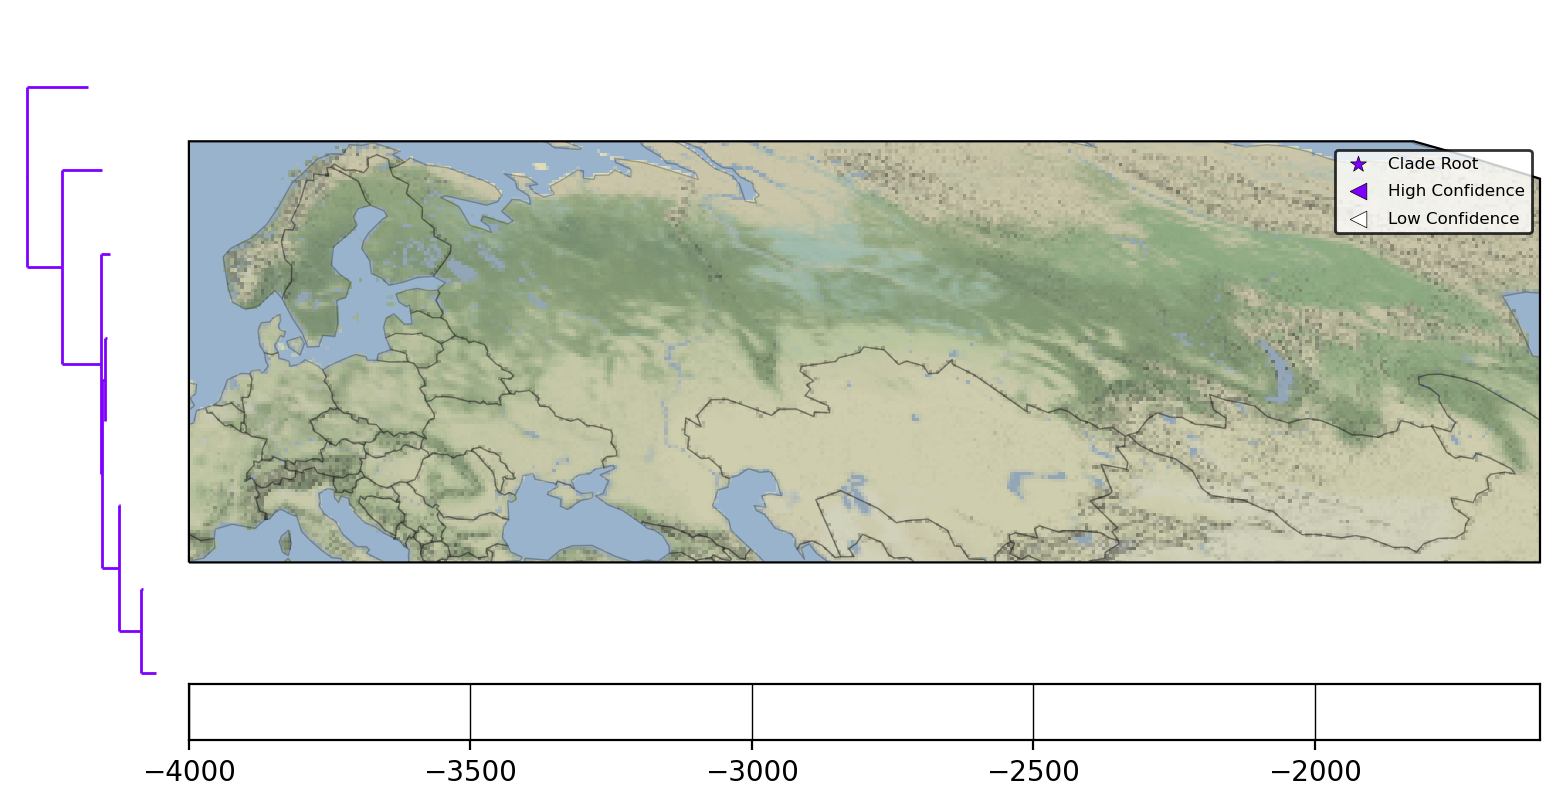

In [18]:
%matplotlib inline

fig_maptime = plt.figure(dpi=200, figsize=(8,4))
gs          = gridspec.GridSpec(3, 2, 
                                figure=fig_maptime, 
                                wspace=0,
                                hspace=0,
                                height_ratios=[6, 6, 1],
                                width_ratios=[1,8],
                               )
ax_tree     = fig_maptime.add_subplot(gs[0:3, 0])
ax_map      = fig_maptime.add_subplot(gs[0:2, 1], projection=ccrs.Mollweide())
ax_time     = fig_maptime.add_subplot(gs[2, 1])

# Customize Tree Axis
lw_orig = plt.rcParams["lines.linewidth"]
plt.rc("lines", linewidth=1)    
Phylo.draw(clade,
             axes=ax_tree,
             show_confidence=False, 
             label_func = lambda x: '',
             do_show=False,
            )
plt.rc("lines", linewidth=lw_orig)    
ax_tree.set_title("")
ax_tree.axis("off")

# -------------------------------
# Customize Map Axis
ax_map.add_image(BASEMAP, 4)
world_polygons.plot(ax=ax_map, color="grey", alpha=0.25, ec="black", lw=0.5, transform=ccrs.PlateCarree())
mb = Polygon(clade_gdf['geometry']).bounds
xb, yb = 10, 8
map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
ax_map.set_extent(map_bounds, crs=ccrs.PlateCarree()) 

# -------------------------------
# Customize Time Axis
ax_time.set_xticks(time_xticks)
ax_time.set_xlim(min_date, max_date)
ax_time.set_ylim(0,0.1)
ax_time.set_yticks([])
[ax_time.axvline(x, color="black", alpha=1) for x in time_xticks]
time_line = ax_time.axvline(x=0, color='grey', lw=5, alpha=0.75)

plt.subplots_adjust(top = 1, bottom = 0.1, right = 0.97, left = 0.02, 
            hspace = 0, wspace = 0)
plt.margins(0,0)


ax_map.scatter(x=1000,y=1000,ec="black", fc=root_color, marker="*", lw=0.25, label="Clade Root") 
ax_map.scatter(x=1000,y=1000,ec="black", fc=attr_color, marker="<", lw=0.25, label="High Confidence") 
ax_map.scatter(x=1000,y=1000,ec="black", fc="white", marker="<", lw=0.25, label="Low Confidence") 
legend = ax_map.legend(frameon=True, edgecolor="black", 
                       fontsize=6,
                       #bbox_to_anchor=(1.27, 1.03), 
                       #loc='upper right'
                      )
legend.get_frame().set_linewidth(1)

    
def animate_init():
    time_line.set_data([],[])
    
    # Setup legend   
    return time_line,

def animate_update(frame, progressive=False):
    frame_date = animate_dict[frame]

    # Timeline animation
    time_line.set_data([frame_date,frame_date], [0,1])
            
    # Check for connections
    for connection in network_connections: 
        origin_name = connection.get_label().split(",")[0]
        origin_date = clade_df["timetree_num_date"][origin_name]
        dest_name = connection.get_label().split(",")[1]
        dest_date = clade_df["timetree_num_date"][dest_name]
        dest_geom = clade_gdf["geometry"][dest_name]
        dest_geo   = clade_df["Mugration_" + geo_attr][dest_name]
        dest_size  = sizes_dict[geo_attr.lower()][dest_geo] 
        
        # Plot the root
        if frame == 0:
            ax_map.add_line(copy.copy(root_marker))
        # This marker will be plotted in future animation
        if origin_date > frame_date: continue
       
        num_seg = math.ceil((dest_date - origin_date) / frame_step) 
        date_seg_delta = (dest_date - origin_date)/ num_seg
        
        marker = lines.Line2D([dest_geom.x], 
                [dest_geom.y],
                marker="o",
                markerfacecolor=dest_color, 
                markeredgecolor="black", 
                markeredgewidth=0.5,
                markersize=dest_size, 
                zorder=3,
                label=dest_name, 
                transform=ccrs.PlateCarree(),
            )
                
        # Option 1) Non-Progressive Lines
        if not progressive or num_seg <= 1:
            if dest_date <= frame_date:
                # Check if it was previously plotted
                if dest_date > animate_dict[frame - 1]:
                    ax_map.add_line(copy.copy(connection)) 
                    
        # Option 2) Progressive Lines
        else:
            conn_seg = segment_line(connection, num_seg, cumulative=True)
            for i in range(1,len(conn_seg) + 1):
                seg_date = origin_date + (date_seg_delta * i)
                if seg_date <= frame_date:
                    # Check if it was previously plotted
                    if seg_date > animate_dict[frame - 1]: 
                        ax_map.add_line(copy.copy(conn_seg[i - 1]))
                        
        # Add Markers
        if dest_date > frame_date: continue
        # Check if it was previously plotted
        if dest_date <= animate_dict[frame - 1]: continue
        ax_map.add_line(copy.copy(marker))                
                                                 
    return time_line,

#animate_init()
#for i in range(0,1):
#     animate_update(i, progressive=True)

print("Animation will be {} frames.".format(len(animate_dict)))
ani = animation.FuncAnimation(
    fig=fig_maptime, 
    func=animate_update,
    fargs=(True,),
    init_func=animate_init,
    interval=spf,
    frames=len(animate_dict), 
    #frames=1,
    blit=True,
    repeat=True
    )

## MP4

In [19]:
#HTML(ani.to_html5_video())
out_path = os.path.join(outdir, "geo_animate_{}.mp4".format(attr_val))
ani.save(out_path, writer="ffmpeg")

## Javascript Widget

In [ ]:
from IPython.display import HTML
#plt.rcParams['animation.html'] = 'jshtml'
HTML(copy.deepcopy(ani).to_jshtml())

## Gif

In [ ]:
out_path = os.path.join(outdir, "geo_animate_{}.gif".format(attr_val))
ani.save(out_path, writer="imagemagick")

In [ ]:
import sys, importlib
importlib.reload(sys.modules['config'])
from config import *